In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cisc-873-dm-w24-a3/sample_submission.csv
/kaggle/input/cisc-873-dm-w24-a3/x_test.csv
/kaggle/input/cisc-873-dm-w24-a3/xy_train.csv


# Problem Formulation:

**Define the problem**
A multitude of social concerns have arisen as a result of incorrect information on the Internet due to the growth of social networks and their engagement in other domains like politics.
By examining the headline of a particular Reddit post, we will be able to determine whether or not it is fake news.

**What is the input?**
The text feature is used as the input. It has words in a variety of formats.

**What is the output?**
Whether or not a particular Reddit post is fake news. The label column in the dataset is output.

**What data mining function is required?**
In this instance, binary classification will be used to determine whether a certain Reddit post is fake news or not by classifying data points into two groups: fake or not and 0 or 1.

**What could be the challenges?**
There are several word forms in the data.
There are outlier values in the datasets.
Determine whether a particular Reddit post is fake news or not based only on its title.

**What is the impact?**
When I build a new system, I can give it the ability to determine whether or not a certain Reddit post is fake news.

**What is an ideal solution?**
My subsequent attempts have shown that the ideal strategy is to utilize Bayesian Search and Random Forest Classifier with Cross Validation, as it gives me the greatest Kaggle score.


# Answer the questions below (briefly):

**🌈 What is the difference between Character n-gram and Word n-gram? Which one tends to suffer more from the OOV issue?**
🌈 They are two methods for extracting features from text: word n-grams and character n-grams. Text is tokenized into sequences of characters using character n-grams and words into sequences of words using word n-grams. Character n-grams are more susceptible to OOV (Out-of-Vocabulary) problems since they can produce a lot of unique n-grams when working with uncommon or obscure words.

**🌈 What is the difference between stop word removal and stemming? Are these techniques language-dependent?**
🌈 The technique of removing frequent words from literature that may not have any meaning—such as "the," "is," and "and"—is known as stop word removal. The process of reducing words to their root or base, however, is known as stemming (e.g., "running" -> "run"). These methods work with many languages and are not language-specific.

**🌈 Is tokenization techniques language dependent? Why?**
🌈 Given that different languages may have different laws regarding word boundaries and structures, tokenization procedures can vary depending on the language. Tokenization in Chinese may necessitate more intricate techniques like segmentation, whereas tokenization in English may just require splitting on whitespace and punctuation.

**🌈 What is the difference between count vectorizer and tf-idf vectorizer? Would it be feasible to use all possible n-grams? If not, how should you select them?**
🌈 Both the TF-IDF vectorizer and the count vectorizer are feature extraction methods for textual data. While TF-IDF vectorizer considers both term frequency and inverse document frequency to account for word importance in a document, count vectorizer encodes text as a matrix of word frequencies. Using every n-gram that could exist is not practical because doing so would result in high dimensionality and possibly overfitting. The particular challenge and dataset will determine which n-grams are used. Starting with smaller n-gram ranges (such as unigrams and bigrams) and progressively increasing them depending on experimentation and performance evaluation is a frequent practice.

In [46]:
import re
import pickle
import sklearn
import nltk 
from bokeh.io import output_notebook
output_notebook()

from pathlib import Path

# some seeting for pandas and hvplot

pd.options.display.max_columns = 100
pd.options.display.max_rows = 300
pd.options.display.max_colwidth = 100
np.set_printoptions(threshold=2000)

Loading BokehJS ...

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from xgboost import XGBClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from bokeh.models import NumeralTickFormatter
from sklearn.metrics import roc_auc_score
from skopt import BayesSearchCV

# SelectKBest use for Select features according to the k highest scores. mutual_info_classif utilize the mutual information.
from sklearn.feature_selection import SelectKBest, mutual_info_classif


# Provides train/test indices to split data into train/test sets
from sklearn.model_selection import PredefinedSplit

from sklearn.naive_bayes import GaussianNB, MultinomialNB

# import warnings to prevent show warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

# Read data

In [4]:
# reading the training dataset 
df_train = pd.read_csv('/kaggle/input/cisc-873-dm-w24-a3/xy_train.csv', index_col='id') 
# df_train = pd.read_csv('xy_train.csv', index_col='id') 
# reading the testing dataset 
df_test = pd.read_csv('/kaggle/input/cisc-873-dm-w24-a3/x_test.csv', index_col='id') 
# df_test = pd.read_csv('x_test.csv', index_col='id')

In [5]:
df_train

,text,label
id,,
265723,"A group of friends began to volunteer at a homeless shelter after their neighbors protested. ""Se...",0
284269,"British Prime Minister @Theresa_May on Nerve Attack on Former Russian Spy: ""The government has c...",0
207715,"In 1961, Goodyear released a kit that allows PS2s to be brought to heel. https://m.youtube.com/w...",0
551106,"Happy Birthday, Bob Barker! The Price Is Right Host on How He'd Like to Be Remembered | ""As the ...",0
8584,"Obama to Nation: 聙""Innocent Cops and Unarmed Young Black Men Should Not be Dying Before Magic Jo...",0
...,...,...
70046,"Finish Sniper Simo H盲yh盲 during the invasion of Finland by the USSR (1939, colorized)",0
189377,"Nigerian Prince Scam took $110K from Kansas man; 10 years later, he's getting it back",1
93486,Is It Safe To Smoke Marijuana During Pregnancy? You鈥檇 Be Surprised Of The Answer | no,0


In [6]:
df_test

,text
id,
0,stargazer
1,yeah
2,PD: Phoenix car thief gets instructions from YouTube video
3,"As Trump Accuses Iran, He Has One Problem: His Own Credibility"
4,"""Believers"" - Hezbollah 2011"
...,...
59146,Bicycle taxi drivers of New Delhi
59147,Trump blows up GOP's formula for winning House races
59148,"Napoleon returns from his exile on the island of Elba. (March 1815), Colourised"


# Check nulls

In [95]:
df_train.isna().sum()

text           0
label          0
text_clean     0
text_clean2    0
dtype: int64

In [8]:
df_test.isna().sum()

text    0
dtype: int64

**there are no nulls in data**

# Check duplicates

In [10]:
df_train.duplicated().sum()

345

In [5]:
df_train=df_train.drop_duplicates()

In [15]:
len(df_test)

59151

In [11]:
df_test.duplicated().sum()

2590

# Cleaning and preprocessing

Create Function for remove any html tags, remove any digits, remove any single letter chars, convert all whitespaces to single wspace, make all lowercase words, remove any stopwords, remove any punctuation and make stemming. remove the noise data in training data.

In [6]:
# required package for tokenization.
nltk.download('punkt') 
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# First text preprocessing technique

In [92]:
nltk.data.path.append('/kaggle/working/nltk_data') 

nltk.download('punkt', download_dir='/kaggle/working/nltk_data')       # Tokenizer Model
nltk.download('stopwords', download_dir='/kaggle/working/nltk_data')   # Stopword lists
nltk.download('wordnet', download_dir='/kaggle/working/nltk_data')

[nltk_data] Downloading package punkt to /kaggle/working/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Initialize the lemmatizer and set of stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_text(text, for_embedding=False):
    """ steps:
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and lemmatize
        - return the clean text
    """
    re_wspace = re.compile(r"\s+", re.IGNORECASE)
    re_tags = re.compile(r"<[^>]+>")
    re_ASII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    re_single_char = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        re_ASII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        re_single_char = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(re_tags, " ", text)
    text = re.sub(re_ASII, " ", text)
    text = re.sub(re_single_char, " ", text)
    text = re.sub(re_wspace, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no lemmatization, lowering, punctuation, or stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            lemmatizer.lemmatize(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

In [ ]:
# Clean texts training data 
df_train["text_clean"] = df_train.loc[df_train["text"].str.len() > 0, "text"] # get all text data the length it greater than 0 in training data
# call clean_text of method to apply it on text_clean feature in traing data
df_train["text_clean"] = df_train["text_clean"].map(
    lambda x: clean_text(x, for_embedding=False) if isinstance(x, str) else x  # check if text is instance of string
) 

# Second text preprocessing technique

In [65]:
# for stemming algorithm
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words("english"))


# Make Function to clean text
def clean_text(text, for_embedding=False):
    """ steps:
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
        - return the clean text
    """
    re_wspace = re.compile(r"\s+", re.IGNORECASE)
    re_tags = re.compile(r"<[^>]+>")
    re_ASII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    re_single_char = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        re_ASII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        re_single_char = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(re_tags, " ", text)
    text = re.sub(re_ASII, " ", text)
    text = re.sub(re_single_char, " ", text)
    text = re.sub(re_wspace, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

In [66]:
# Clean texts training data 
df_train["text_clean"] = df_train.loc[df_train["text"].str.len() > 0, "text"] # get all text data the length it greater than 0 in training data
# call clean_text of method to apply it on text_clean feature in traing data
df_train["text_clean"] = df_train["text_clean"].map(
    lambda x: clean_text(x, for_embedding=False) if isinstance(x, str) else x  # check if text is instance of string
) 

In [67]:
df_test["text_clean"] = df_test["text"]
df_test["text_clean"] = df_test["text_clean"].map(
    lambda x: clean_text(x, for_embedding=False) if isinstance(x, str) else x
)

In [19]:
df_train

,text,label,text_clean
id,,,
265723,"A group of friends began to volunteer at a homeless shelter after their neighbors protested. ""Se...",0,group friend began volunt homeless shelter neighbor protest see anoth person also need natur lik...
284269,"British Prime Minister @Theresa_May on Nerve Attack on Former Russian Spy: ""The government has c...",0,british prime minist theresa may nerv attack former russian spi govern conclud high like russia ...
207715,"In 1961, Goodyear released a kit that allows PS2s to be brought to heel. https://m.youtube.com/w...",0,goodyear releas kit allow ps brought heel https youtub com watch alxulk cg zwillc fish midatlant...
551106,"Happy Birthday, Bob Barker! The Price Is Right Host on How He'd Like to Be Remembered | ""As the ...",0,happi birthday bob barker price right host like rememb man said ave pet spay neuter fuckincorpor...
8584,"Obama to Nation: 聙""Innocent Cops and Unarmed Young Black Men Should Not be Dying Before Magic Jo...",0,obama nation innoc cop unarm young black men die magic johnson jimbobshawobodob olymp athlet sho...
...,...,...,...
70046,"Finish Sniper Simo H盲yh盲 during the invasion of Finland by the USSR (1939, colorized)",0,finish sniper simo yh invas finland ussr color
189377,"Nigerian Prince Scam took $110K from Kansas man; 10 years later, he's getting it back",1,nigerian princ scam took kansa man year later get back
93486,Is It Safe To Smoke Marijuana During Pregnancy? You鈥檇 Be Surprised Of The Answer | no,0,safe smoke marijuana pregnanc surpris answer


In [68]:
%%time
# Clean texts testing data
df_test["text_clean"] = df_test.loc[df_test["text"].str.len() > 0, "text"] # get all text data the length it greater than 0 in testing data
# call clean_text of method to apply it on text_clean feature in testing data
df_test["text_clean"] = df_test["text_clean"].map(
    lambda x: clean_text(x, for_embedding=False) if isinstance(x, str) else x  # check if text is instance of string
)

CPU times: user 16.1 s, sys: 6.91 ms, total: 16.1 s
Wall time: 16.1 s


In [21]:
df_test

,text,text_clean
id,,
0,stargazer,stargaz
1,yeah,yeah
2,PD: Phoenix car thief gets instructions from YouTube video,pd phoenix car thief get instruct youtub video
3,"As Trump Accuses Iran, He Has One Problem: His Own Credibility",trump accus iran one problem credibl
4,"""Believers"" - Hezbollah 2011",believ hezbollah
...,...,...
59146,Bicycle taxi drivers of New Delhi,bicycl taxi driver new delhi
59147,Trump blows up GOP's formula for winning House races,trump blow gop formula win hous race
59148,"Napoleon returns from his exile on the island of Elba. (March 1815), Colourised",napoleon return exil island elba march colouris


we can notice the difference between text and text_clean as  any html tags, remove any digits, remove any single letter chars, convert all whitespaces to single wspace, make all lowercase words, remove any stopwords, remove any punctuation are removed

# Third technique is grammar checker

In [ ]:
import language_tool_python
from language_tool_python import LanguageTool

# Initialize the language tool
tool = LanguageTool('en-US')

# Check grammar in each code snippet
for index, row in df_train.iterrows():
    text = row['code_text']
    matches = tool.check(text)
    print(f"Code Snippet {index + 1}:")
    for match in matches:
        print(f"Error: {match.ruleId} ({match.category})")
        print(f"Message: {match.message}")
        print(f"Suggested Correction: {match.replacements}")
        print("-" * 30)
    print("\n")

# Note: Replace the example DataFrame with your actual data containing code snippets.
# The tool will identify grammar errors and provide suggestions for corrections.
# Adjust the language (e.g., 'en-US') based on your text's language.


In [69]:
# Distribution of ratings
df_train["label"].value_counts(normalize=True)

label
0.0    0.537694
1.0    0.462306
Name: proportion, dtype: float64

<Axes: xlabel='label'>

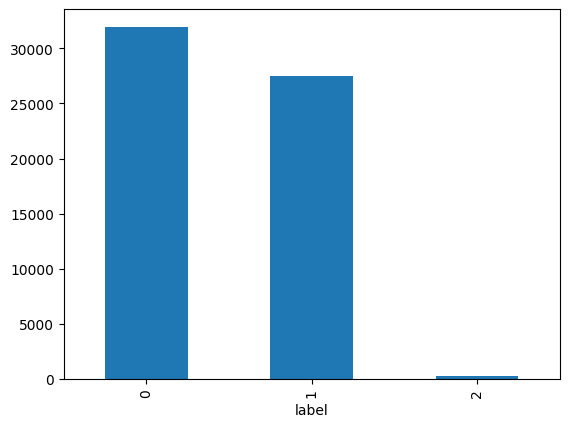

In [26]:
df_train.label.value_counts().plot(kind='bar')

We have identified an infrequent class, and to simplify the problem, we will convert it into a binary classification task by removing this class.

In [70]:
# turn all class 2 to null
df_train.loc[df_train["label"]==2] = np.NaN


# Drop when any of x missing
df_train = df_train[(df_train["text_clean"] != "") & (df_train["text_clean"] != "null")]


df_train = df_train.dropna(
    axis="index", subset=["label", "text", "text_clean"]
).reset_index(drop=True)

In [71]:
# set the tect_clean feature and label to values in training data 
data = df_train["text_clean"]
target = df_train["label"]
X_test = df_test["text_clean"]

# Data splitting

In [72]:
X_train, X_val, y_train, y_val = train_test_split(data, target, train_size = 0.8,  random_state = 42)

# Pipe line Function

In [73]:
def pipline (classifier,analyzer='word'):
    preprocessor = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer(analyzer=analyzer))])
    pipline = Pipeline(  
    steps=[
        ('preprocessor', preprocessor), 
        ('my_classifier', classifier)])
    return pipline

# Trial 1 XGBoost & Grid Search 

we first will tune vectorizer hyperparameters as:

ngram_range

max_df

min_df

In [74]:
params = {
    "preprocessor__tfidf__ngram_range": [(1, 2), (1, 3)],
    "preprocessor__tfidf__max_df":(0.3,0.5,0.7),
    "preprocessor__tfidf__min_df": (10, 30,50),
}

tf_best_params = GridSearchCV(
    pipline(XGBClassifier()), params, cv=2, verbose=1, n_jobs=-1,scoring='roc_auc')

tf_best_params.fit(X_train, y_train)

print('best score {}'.format(tf_best_params.best_score_))
print('best score {}'.format(tf_best_params.best_params_))

Fitting 2 folds for each of 18 candidates, totalling 36 fits
best score 0.8205650951304404
best score {'preprocessor__tfidf__max_df': 0.3, 'preprocessor__tfidf__min_df': 10, 'preprocessor__tfidf__ngram_range': (1, 2)}


In [75]:
best_estimator = tf_best_params.best_estimator_
# Evaluate the best estimator on the val set
y_pred = best_estimator.predict(X_val)
roc_auc = roc_auc_score(y_val, y_pred)
print('ROC AUC score on val set:', roc_auc)

ROC AUC score on val set: 0.7381903691526018


In [17]:
_id=df_test.index
pred_test = tf_best_params.predict_proba(X_test)[:, 1]
pred_df = pd.DataFrame(data={'id': np.asarray(_id), 'label': pred_test})
pred_df.to_csv('submission4.csv', index=False)

# Trial 2 XGBoost & Random Search

tunning hyperparameters for XGBoost as 

max_depth

learning_rate

n_estimators

In [76]:
params = {
    "preprocessor__tfidf__ngram_range": [(1, 2)],
    "preprocessor__tfidf__max_df":(0.3,0.4),
    "preprocessor__tfidf__min_df": (10,20),
    'my_classifier__max_depth': [3, 5, 7],
    'my_classifier__learning_rate': [0.1, 0.01, 0.001],
    'my_classifier__n_estimators': [100, 200, 300]
}

XG_best_params = RandomizedSearchCV(
    pipline(XGBClassifier()), params, cv=2, verbose=1, n_jobs=-1,n_iter=10 ,scoring='roc_auc')

XG_best_params.fit(X_train, y_train)

print('best score {}'.format(XG_best_params.best_score_))
print('best score {}'.format(XG_best_params.best_params_))

Fitting 2 folds for each of 10 candidates, totalling 20 fits
best score 0.8275704341156802
best score {'preprocessor__tfidf__ngram_range': (1, 2), 'preprocessor__tfidf__min_df': 20, 'preprocessor__tfidf__max_df': 0.3, 'my_classifier__n_estimators': 300, 'my_classifier__max_depth': 7, 'my_classifier__learning_rate': 0.1}


In [77]:
best_estimator = XG_best_params.best_estimator_
# Evaluate the best estimator on the val set
y_pred = best_estimator.predict(X_val)
roc_auc = roc_auc_score(y_val, y_pred)
print('ROC AUC score on val set:', roc_auc)

ROC AUC score on val set: 0.7467293927823782


In [84]:
_id=df_test.index
pred_test = XG_best_params.predict_proba(X_test)[:, 1]
pred_df = pd.DataFrame(data={'id': np.asarray(_id), 'label': pred_test})
pred_df.to_csv('submission1.csv', index=False)

# Trial 3 Random Search & Logistic Regression 

tunning hyperparameters for vectorizor as :

max_df

min_df

with tunning hyperparameters for logistic regression :

penalty & C

In [78]:
params = {
    "preprocessor__tfidf__ngram_range": [(1, 2)],
    "preprocessor__tfidf__max_df":(0.3,0.4),
    "preprocessor__tfidf__min_df": (10,20),
    'my_classifier__penalty' : ['l1', 'l2'],
    'my_classifier__C' : [0.001,0.01, 0.03,0.05, 0.06, 0.1, 1]       
}

LR_best_params = RandomizedSearchCV(
    pipline(LogisticRegression()), params, cv=2, verbose=1, n_jobs=-1,n_iter=10 ,scoring='roc_auc')

LR_best_params.fit(X_train, y_train)

print('best score {}'.format(LR_best_params.best_score_))
print('best score {}'.format(LR_best_params.best_params_))

Fitting 2 folds for each of 10 candidates, totalling 20 fits
best score 0.8439080238188515
best score {'preprocessor__tfidf__ngram_range': (1, 2), 'preprocessor__tfidf__min_df': 10, 'preprocessor__tfidf__max_df': 0.4, 'my_classifier__penalty': 'l2', 'my_classifier__C': 0.1}


In [79]:
best_estimator = LR_best_params.best_estimator_
# Evaluate the best estimator on the val set
y_pred = best_estimator.predict(X_val)
roc_auc = roc_auc_score(y_val, y_pred)
print('ROC AUC score on val set:', roc_auc)

ROC AUC score on val set: 0.7634943518171883


In [99]:
_id=df_test.index
pred_test = LR_best_params.predict_proba(X_test)[:, 1]
pred_df = pd.DataFrame(data={'id': np.asarray(_id), 'label': pred_test})
pred_df.to_csv('submission2.csv', index=False)

# Trial 4
# try it for analyzer >>char

In [80]:
params = {
    "preprocessor__tfidf__ngram_range": [(1, 2)],
    "preprocessor__tfidf__max_df":(0.3,0.4),
    "preprocessor__tfidf__min_df": (10,20),
    'my_classifier__penalty' : ['l1', 'l2'],
    'my_classifier__C' : [0.001,0.01, 0.03,0.05, 0.06, 0.1, 1]       
}

LR_best_params = RandomizedSearchCV(
    pipline(LogisticRegression(),analyzer="char"), params, cv=2, verbose=1, n_jobs=-1,n_iter=10 ,scoring='roc_auc')

LR_best_params.fit(X_train, y_train)

print('best score {}'.format(LR_best_params.best_score_))
print('best score {}'.format(LR_best_params.best_params_))

Fitting 2 folds for each of 10 candidates, totalling 20 fits
best score 0.7123385082757895
best score {'preprocessor__tfidf__ngram_range': (1, 2), 'preprocessor__tfidf__min_df': 20, 'preprocessor__tfidf__max_df': 0.3, 'my_classifier__penalty': 'l2', 'my_classifier__C': 1}


In [81]:
best_estimator = LR_best_params.best_estimator_
# Evaluate the best estimator on the val set
y_pred = best_estimator.predict(X_val)
roc_auc = roc_auc_score(y_val, y_pred)
print('ROC AUC score on val set:', roc_auc)

ROC AUC score on val set: 0.6470547252856347


**char performance is bad comparing with word analyzer performance**

In [107]:
_id=df_test.index
pred_test = LR_best_params.predict_proba(X_test)[:, 1]
pred_df = pd.DataFrame(data={'id': np.asarray(_id), 'label': pred_test})
pred_df.to_csv('submission3.csv', index=False)

# Trial 5 Random Forest & Random Search

​
tunning hyperparameters for vectorizor as :
​
max_df
​
min_df
​
with tunning hyperparameters for random forest

n_estimators

criterion

In [27]:
params = {
    "preprocessor__tfidf__ngram_range": [(1, 2)],
    "preprocessor__tfidf__max_df":(0.3,0.4),
    "preprocessor__tfidf__min_df": (10,20),
    'my_classifier__n_estimators': range(500, 1000, 100),
    'my_classifier__criterion' :['gini', 'entropy']
    
}

RF_best_params = RandomizedSearchCV(
                    pipline(RandomForestClassifier()), params, cv=2, verbose=1, n_jobs=-1,n_iter=10 ,scoring='roc_auc')

RF_best_params.fit(X_train, y_train)

print('best score {}'.format(RF_best_params.best_score_))
print('best score {}'.format(RF_best_params.best_params_))

Fitting 2 folds for each of 10 candidates, totalling 20 fits
best score 0.8361877481770618
best score {'preprocessor__tfidf__ngram_range': (1, 2), 'preprocessor__tfidf__min_df': 10, 'preprocessor__tfidf__max_df': 0.3, 'my_classifier__n_estimators': 900, 'my_classifier__criterion': 'entropy'}


In [34]:
best_estimator = RF_best_params.best_estimator_

# Evaluate the best estimator on the val set
y_pred = best_estimator.predict(X_val)
roc_auc = roc_auc_score(y_val, y_pred)
print('ROC AUC score on val set:', roc_auc)

ROC AUC score on val set: 0.7638734770804603


In [33]:
_id=df_test.index
pred_test = RF_best_params.predict_proba(X_test)[:, 1]
pred_df = pd.DataFrame(data={'id': np.asarray(_id), 'label': pred_test})
pred_df.to_csv('submission5.csv', index=False)

from all trials above random forest is the best module with :

tfidf__ngram_range: (1, 2)

tfidf__min_df: 10

tfidf__max_df: 0.3

tfidf__analyzer: word

classifier__n_estimators: 900

classifier__criterion: 'entropy'



# Trial 6 Random Forest & Bayesian Search

In [93]:
params = {
    "preprocessor__tfidf__ngram_range": [(1, 2)],
    "preprocessor__tfidf__max_df": (0.3, 0.4),
    "preprocessor__tfidf__min_df": (10, 20),
    'my_classifier__n_estimators': (500, 1000),
    'my_classifier__criterion': ['gini', 'entropy']
}

# Perform Bayesian optimization search
RF_best_params = BayesSearchCV(pipline(RandomForestClassifier()), params, cv=2, n_iter=10, scoring='roc_auc', n_jobs=-1, verbose=1)
RF_best_params.fit(X_train, y_train)

print('Best score:', RF_best_params.best_score_)
print('Best parameters:', RF_best_params.best_params_)

ValueError: can only convert an array of size 1 to a Python scalar